

# Autoencoder.
## Variational autoencoders (VAE)





**Цель данного проекта, написать autoencoder, который будет слегка изменять рисунки цветов.**

**Причем в качестве train dataset будут использованы фотографии настоящих цветов**

In [1]:
import numpy as np
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import skimage.io
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F

**Загружаем цветочки, сразу меняя размер фото**

In [2]:
images = []
from skimage.io import imread
from skimage.transform import resize
size = (128, 128)
import os
path = r'C:\Users\Андрей\Desktop\Домашние задания\stepik\deep learning\8 home work\archive\flowers'

for root, dirs, files in os.walk(path):
    for file_ in files:
        if file_.endswith('.jpg'):
            images.append(resize(imread(os.path.join(root, file_)), size, mode='constant', anti_aliasing=True,))


In [3]:
print(len(images))

13866


In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image

from torch.utils.data import Dataset, DataLoader
import cv2
import glob
import numpy
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

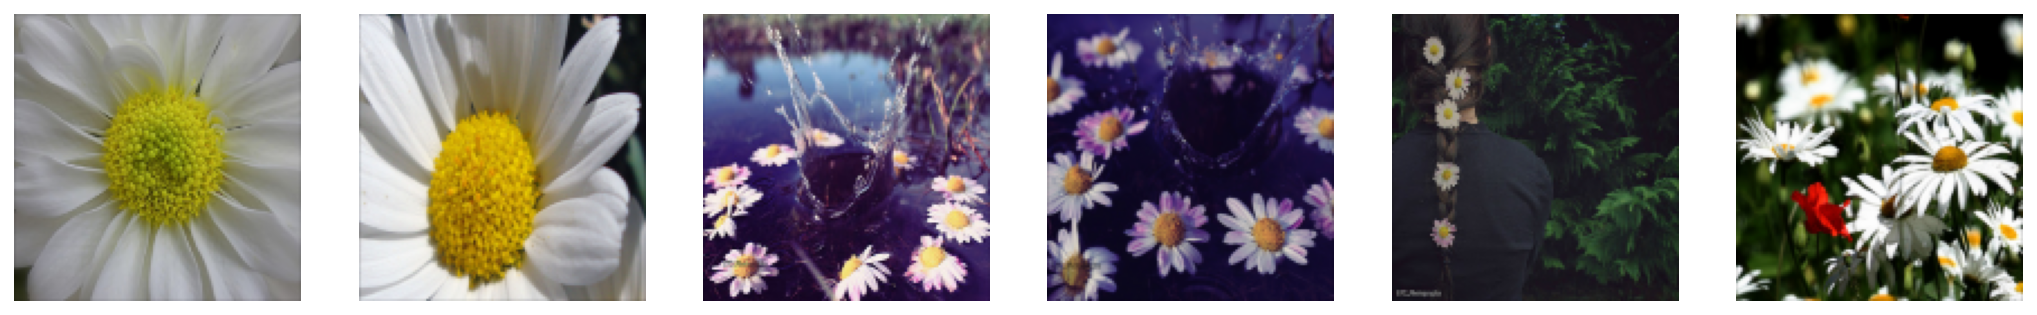

In [5]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])
plt.show();

**Сама сверточная нейросеть**

In [11]:
class LinearVAE(nn.Module):
    def __init__(self, latent_dim=256, enc_out_dim=512):
        super(LinearVAE, self).__init__()

        self.flatten = nn.Flatten()
        self.latent_dim = latent_dim
        # encoder
        self.encoder1 = nn.Sequential(
                                        nn.Conv2d(in_channels=3,out_channels=512,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True)
            
                                        )
        self.encoder2 = nn.Sequential(
                                        nn.Conv2d(in_channels=512,out_channels=256,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(inplace=True)
                                        )
        self.encoder3 = nn.Sequential(
                                        nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU(inplace=True)
                                        )
        self.encoder4 = nn.Sequential(
                                        nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(8),
                                        nn.ReLU(inplace=True)
                                        )
        
        #latent space
        self.fc_mu_encode = nn.Sequential(
                                     nn.Linear(enc_out_dim, latent_dim*2),
                                     nn.Dropout(0.25),
                                     nn.ReLU(inplace=True)
                                    )
        
        self.fc_var = nn.Linear(enc_out_dim, latent_dim) 
        
        self.fc_decode = nn.Sequential(
                                     nn.Linear(latent_dim, enc_out_dim),
                                     nn.Dropout(0.25),
                                     nn.ReLU(inplace=True)
                                    )

        
        
        self.maxpool_with_argmax=nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)
        self.unpool=nn.MaxUnpool2d(2,2)

 
        # decoder 
        self.decoder4 = nn.Sequential(
                                        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU(inplace=True)
                                        )
        self.decoder3 = nn.Sequential(
                                        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(inplace=True)
                                        )
        self.decoder2 = nn.Sequential(
                                        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True)
                                        )
        self.decoder1 = nn.Sequential(
                                        nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(in_channels=512,out_channels=3,kernel_size=3,stride=1,padding=1),
                                        nn.BatchNorm2d(3),
                                        nn.ReLU(inplace=True)
                                        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var) 
        eps = torch.randn_like(std)
        sample = mu + (eps * std) 
        return sample
 
    def forward(self, x):
        # encoding
        x = self.encoder1(x)
        x, indices1 = self.maxpool_with_argmax(x)
        x = self.encoder2(x)
        x, indices2 = self.maxpool_with_argmax(x)
        x = self.encoder3(x)
        x, indices3 = self.maxpool_with_argmax(x)
        x = self.encoder4(x)
        x, indices4 = self.maxpool_with_argmax(x)
        
        x2 = self.flatten(x)
        x2 = self.fc_mu_encode(x2)
        
        #latent space
        
        x2 = x2.view(-1, 2, self.latent_dim)
        mu = x2[:, 0, :]
        log_var = x2[:, 1, :] 
        z = self.reparameterize(mu, log_var)      
        x2 = self.fc_decode(z)
        x = x2.view(-1, 8, 8, 8)
        
        # decoding
        x = self.unpool(x,indices=indices4)
        x = self.decoder4(x)
        x = self.unpool(x,indices=indices3)
        x = self.decoder3(x)
        x = self.unpool(x,indices=indices2)
        x = self.decoder2(x)
        x = self.unpool(x,indices=indices1)
        x = self.decoder1(x)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, log_var

**Функция ошибки**

In [12]:
def KL_divergence(mu, logsigma):

    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):

    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

**Обучим модель:**

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = LinearVAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [14]:
train_photos, val_photos = train_test_split(images, train_size=0.9, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=2)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=2)

In [15]:
n_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        batch = batch.permute(0,3,1,2).float()
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(device))
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.permute(0,3,1,2).float()
            reconstruction, mu, logsigma = autoencoder(batch.to(device))
            loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
#autoencoder.load_state_dict(torch.load('weights_autoencoder_low_latent.pth')) # загрузка весов модели

**Посмотрим, как наш VAE кодирует и восстанавливает картинки:**

In [17]:
autoencoder.eval()
ground_truth = []
result = []
with torch.no_grad():
      for batch in val_loader:
            ground_truth.append(batch.numpy())
            batch = batch.permute(0,3,1,2).float()
            reconstruction, mu, logsigma = autoencoder(batch.to(device))
            reconstruction = reconstruction.permute(0,2,3,1)
            result.append(reconstruction.cpu().detach().numpy())

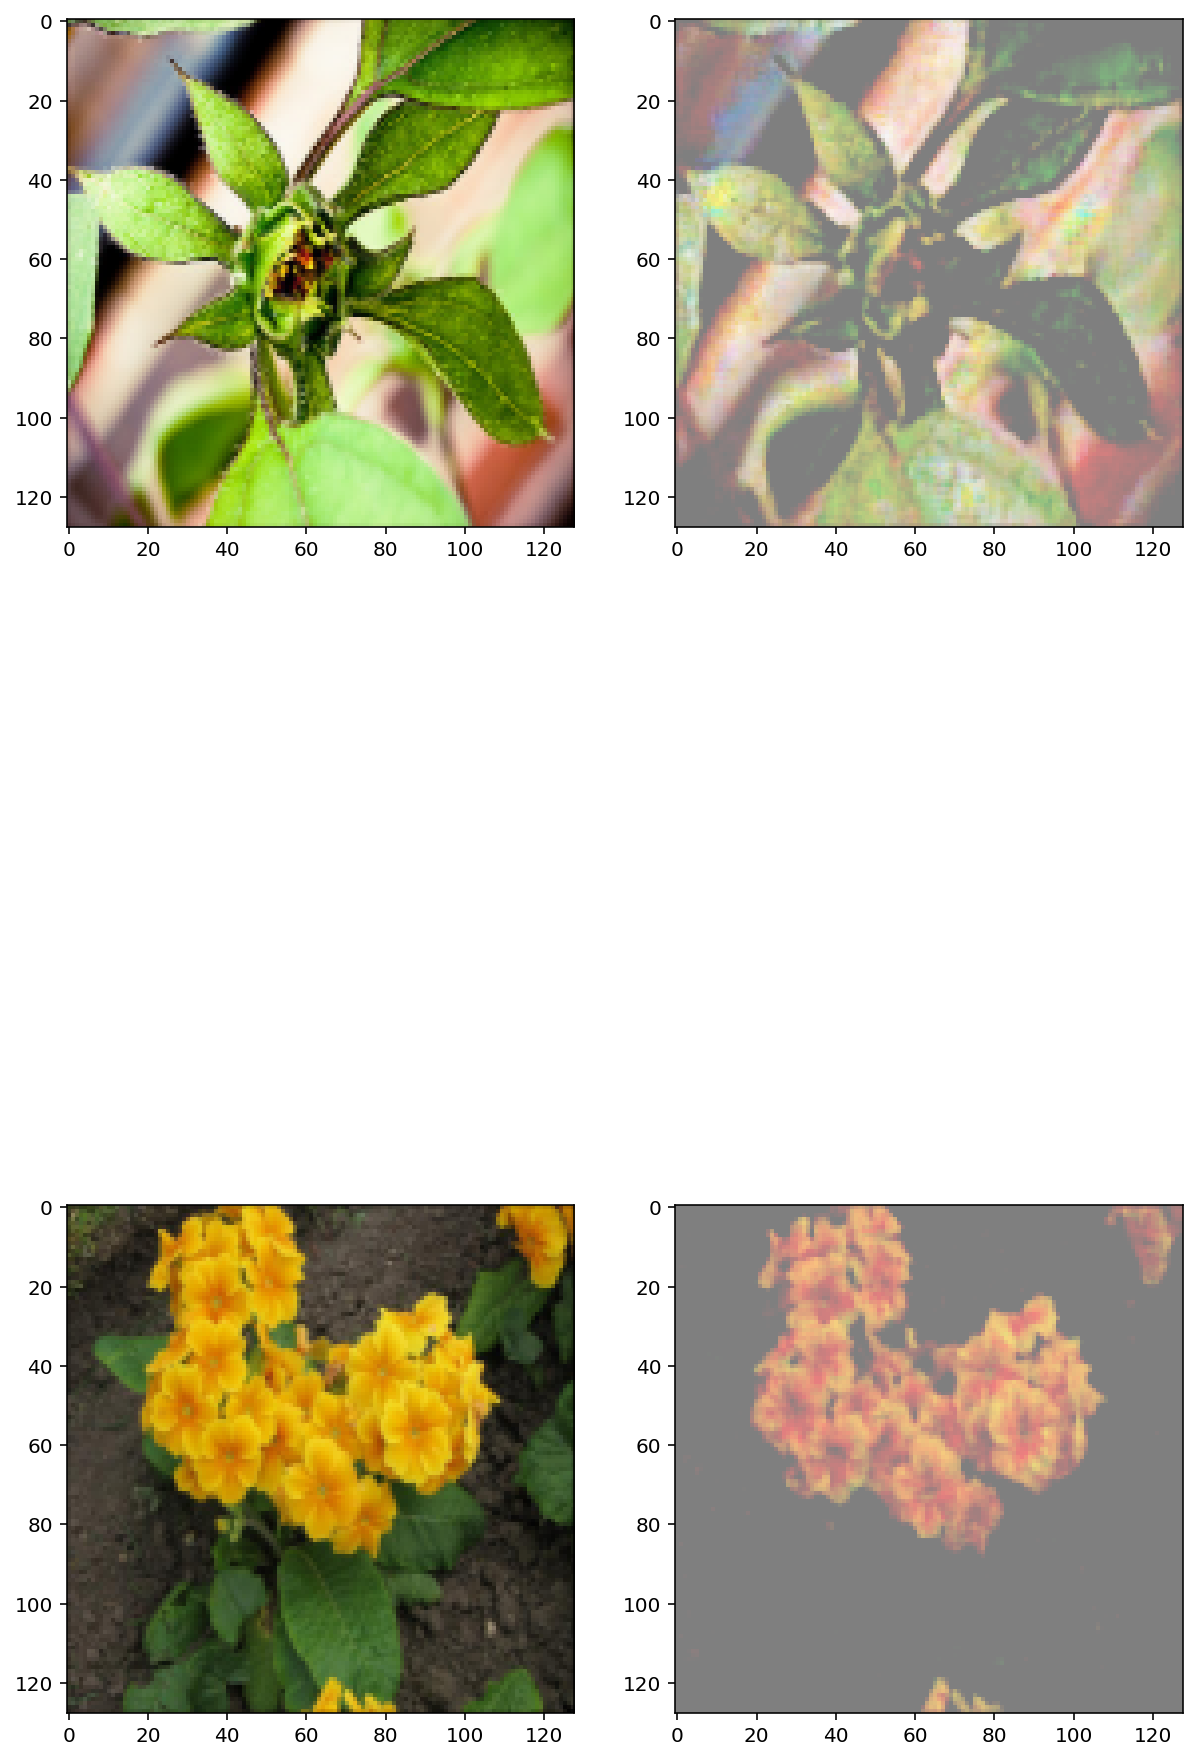

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 20))
for i, (gt, res) in enumerate(zip(ground_truth[0:2][0], result[0:2][0])):
    plt.subplot(2, 2, 2*i+1)
    plt.imshow(gt)
    plt.subplot(2, 2, 2*i+2)
    plt.imshow(res)

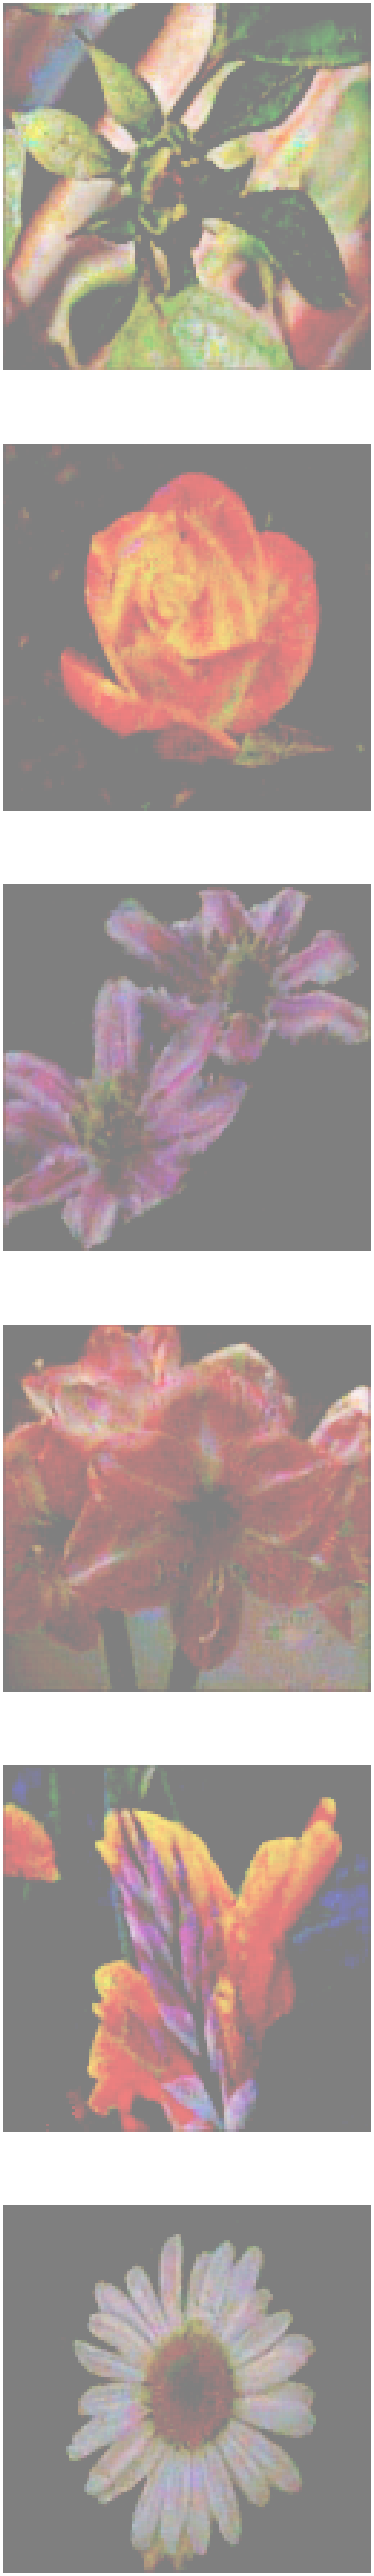

In [19]:
plt.figure(figsize=(15, 100))
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.axis("off")
    plt.imshow(result[i][0])
plt.show();

**А теперь возьмем несколько различных рисунков и пропустим через сеть**

In [20]:
images_val = []

path = r'C:\Users\Андрей\Desktop\Домашние задания\свои проекты\images_val'

for root, dirs, files in os.walk(path):
    for file_ in files:
        if file_.endswith('.jpg'):
            print(file_)
            images_val.append(imread(os.path.join(root, file_)))
size = (128, 128)
X_val = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images_val]

images (1).jpg
images (2).jpg
images (3).jpg
images (4).jpg
images (5).jpg
images.jpg
Без названия (1).jpg
Без названия (2).jpg
Без названия.jpg


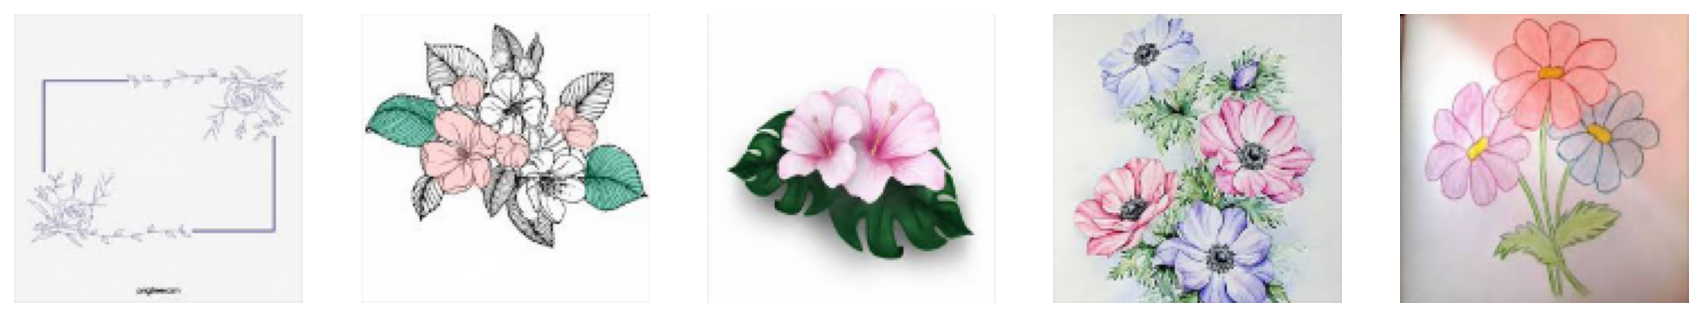

In [21]:
plt.figure(figsize=(15, 30))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(X_val[i])
plt.show();

In [22]:
X_val_load = torch.utils.data.DataLoader(X_val, batch_size=10)

In [23]:
autoencoder.eval()
with torch.no_grad():
      for batch in X_val_load:
            batch.shape
            ground_truth = batch.numpy()
            batch = batch.permute(0,3,1,2).float()
            reconstruction, mu, logsigma = autoencoder(batch.to(device))
            reconstruction = reconstruction.permute(0,2,3,1)
            result = reconstruction.cpu().detach().numpy()
        
            break

9


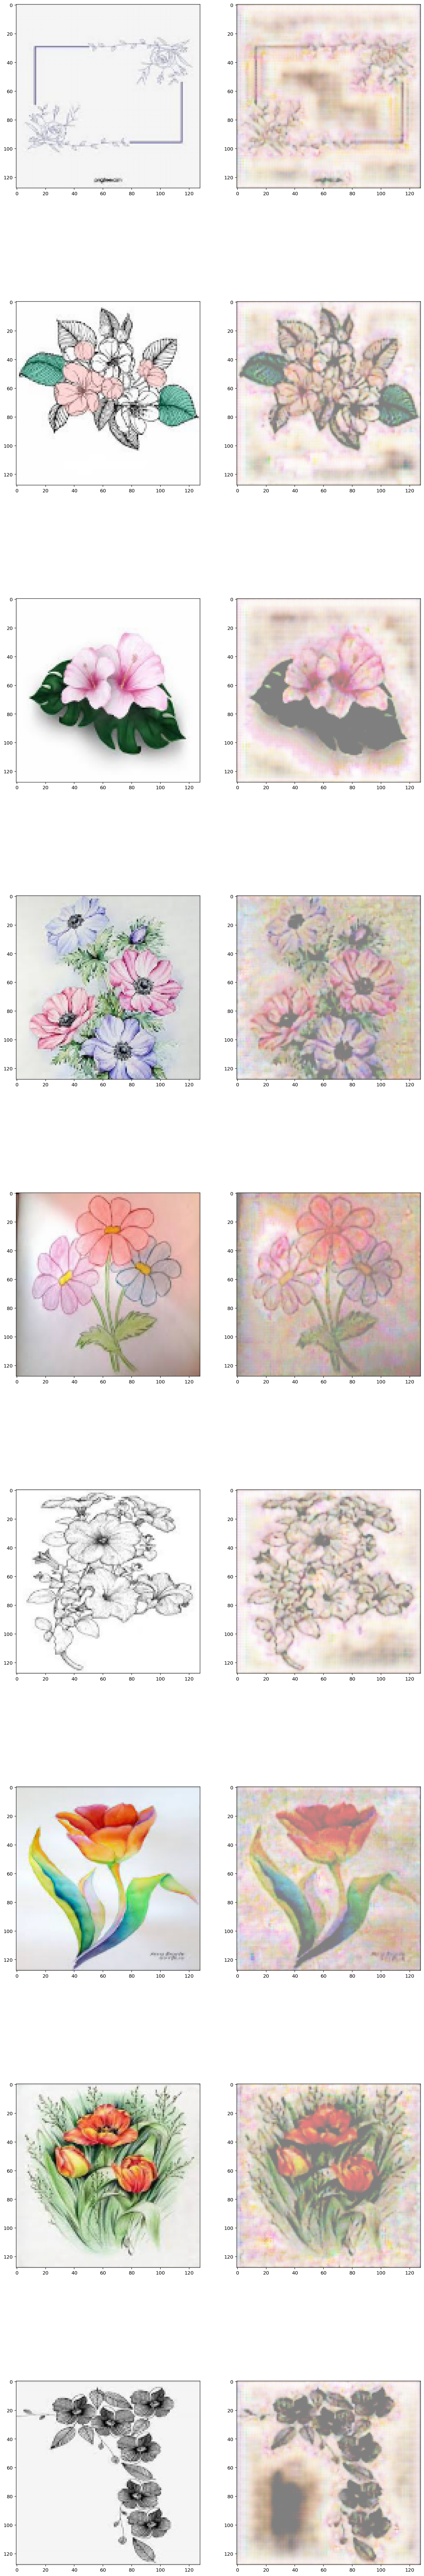

In [24]:
len_data = len(result)
print(len_data)
plt.figure(figsize=(15, 100))
for i, (gt, res) in enumerate(zip(ground_truth[:len_data], result[:len_data])):
    plt.subplot(len_data, 2, 2*i+1)
    plt.imshow(gt)
    plt.subplot(len_data, 2, 2*i+2)
    plt.imshow(res)

In [25]:
torch.save(autoencoder, "autoencoder_256_latent_20_epoch.pth")
torch.save (autoencoder.state_dict (), "weights_autoencoder_256_latent_20_epoch.pth")

**Некоторые реконструкции получились очень даже симпотичными, однако необходимо эксперементировать дальше с большим латентным пространством, а так же колличеством эпох обучения**